# Libraries

In [1]:
import  pandas            as pd
import  numpy             as np
import  plotly.express    as px
import  matplotlib.pyplot as plt
import  plotly.graph_objs as go
import  plotly.io         as pio
from    datetime import datetime

In [2]:
RANDOM_SEED = np.random.seed(31)


In [3]:
cd ..\

c:\Users\victo\Downloads\00. Estudo Data Science\predict_payment_default


c:\Users\victo\Downloads\00. Estudo Data Science\predict_payment_default\venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# db info

In [4]:
df_info = pd.read_csv('data\database_info.csv',
                      encoding='utf-8',
                      sep=','
                      )
df_info['ID_CLIENTE'] = df_info['ID_CLIENTE'].astype(object)
df_info['SAFRA_REF'] = pd.to_datetime(df_info['SAFRA_REF']).dt.to_period('M')
df_info.sort_values(['ID_CLIENTE', 'SAFRA_REF'], inplace=True)
df_info.reset_index(inplace=True, drop=True)
df_info.head()

ID_CLIENTE SAFRA_REF  RENDA_MES_ANTERIOR  NO_FUNCIONARIOS
0  8784237149961904   2018-09            300502.0            107.0
1  8784237149961904   2018-10            499238.0             98.0
2  8784237149961904   2018-11            256117.0            104.0
3  8784237149961904   2018-12            433897.0            105.0
4  8784237149961904   2019-01            370549.0            112.0

In [5]:
df_info.shape

(24401, 4)

In [6]:
df_info.dtypes

ID_CLIENTE               object
SAFRA_REF             period[M]
RENDA_MES_ANTERIOR      float64
NO_FUNCIONARIOS         float64
dtype: object

In [7]:
df_info.isna().sum()

ID_CLIENTE            0
SAFRA_REF             0
RENDA_MES_ANTERIOR    0
NO_FUNCIONARIOS       0
dtype: int64

In [8]:
df_info.describe()

RENDA_MES_ANTERIOR  NO_FUNCIONARIOS
count        2.440100e+04     24401.000000
mean         2.885432e+05       117.820540
std          2.114604e+05        21.439451
min          1.050000e+02         0.000000
25%          1.336420e+05       106.000000
50%          2.410160e+05       118.000000
75%          3.922190e+05       131.000000
max          1.682759e+06       198.000000

In [9]:
fig = px.histogram(df_info, x='RENDA_MES_ANTERIOR', marginal='box')
fig.update_layout(height=400,
                  width=800,
                  showlegend=False,
                  title='Distribution of RENDA_MES_ANTERIOR',
                  margin=dict(l=10, r=10, b=10, t=30, pad=0)
                  )
fig.show()

In [10]:
fig = px.histogram(df_info, x='NO_FUNCIONARIOS', marginal='box')
fig.update_layout(height=400,
                  width=800,
                  showlegend=False,
                  title='Distribution of NO_FUNCIONARIOS',
                  margin=dict(l=10, r=10, b=10, t=30, pad=0)
                  )
fig.show()

In [11]:
# Drop registers with 0 NO_FUNCIONARIOS
df_info_processed = df_info[df_info['NO_FUNCIONARIOS'] != 0].copy()
df_info_processed.reset_index(drop=True, inplace=True)
df_info_processed

ID_CLIENTE SAFRA_REF  RENDA_MES_ANTERIOR  NO_FUNCIONARIOS
0         8784237149961904   2018-09            300502.0            107.0
1         8784237149961904   2018-10            499238.0             98.0
2         8784237149961904   2018-11            256117.0            104.0
3         8784237149961904   2018-12            433897.0            105.0
4         8784237149961904   2019-01            370549.0            112.0
...                    ...       ...                 ...              ...
24172  9206030810342980458   2021-08            175291.0            101.0
24173  9206030810342980458   2021-09            535348.0            108.0
24174  9206030810342980458   2021-10             32400.0            101.0
24175  9206030810342980458   2021-11            856312.0            107.0
24176  9206030810342980458   2021-12            577352.0            106.0

[24177 rows x 4 columns]

In [12]:
fig = px.histogram(df_info_processed, x='NO_FUNCIONARIOS', marginal='box')
fig.update_layout(height=400,
                  width=800,
                  showlegend=False,
                  title='Distribution of NO_FUNCIONARIOS',
                  margin=dict(l=10, r=10, b=10, t=30, pad=0)
                  )
fig.show()

# db registration

In [13]:
df_regist = pd.read_csv('data\database_registration.csv',
                        encoding='utf-8',
                        sep=','
                        )

map_flag_pf = {'X': 'PJ', np.nan: 'PF'}
df_regist['FLAG_PF'] = df_regist['FLAG_PF'].map(map_flag_pf)

df_regist['CEP_2_DIG'] = df_regist['CEP_2_DIG'].replace({'na': np.nan})
df_regist['CEP_2_DIG']  = df_regist['CEP_2_DIG'] .astype(float)

# Adjust wrong data on DDD to np.nan
df_regist['DDD'] = df_regist['DDD'].apply(lambda x: np.nan if pd.isna(x) else (np.nan if '(' in x or '00' in x or x.startswith('0') else x))
df_regist['DDD'] = df_regist['DDD'].astype(float)

df_regist['DATA_CADASTRO'] = pd.to_datetime(df_regist['DATA_CADASTRO'])
df_regist.head()

ID_CLIENTE DATA_CADASTRO   DDD FLAG_PF SEGMENTO_INDUSTRIAL  \
0  1661240395903230676    2013-08-22  99.0      PF            Serviços   
1  8274986328479596038    2017-01-25  31.0      PF            Comércio   
2   345447888460137901    2000-08-15  75.0      PF            Serviços   
3  1003144834589372198    2017-08-06  49.0      PF            Serviços   
4   324916756972236008    2011-02-14  88.0      PF            Serviços   

  DOMINIO_EMAIL    PORTE  CEP_2_DIG  
0         YAHOO  PEQUENO       65.0  
1         YAHOO    MEDIO       77.0  
2       HOTMAIL  PEQUENO       48.0  
3       OUTLOOK  PEQUENO       89.0  
4         GMAIL   GRANDE       62.0

In [14]:
today = datetime.now().strftime('%Y-%m-%d')
df_regist['IDADE_ANOS_CLIENTE'] = np.round((pd.to_datetime(today) - df_regist['DATA_CADASTRO']).dt.days / 365.25, 0)
df_regist

ID_CLIENTE DATA_CADASTRO   DDD FLAG_PF SEGMENTO_INDUSTRIAL  \
0     1661240395903230676    2013-08-22  99.0      PF            Serviços   
1     8274986328479596038    2017-01-25  31.0      PF            Comércio   
2      345447888460137901    2000-08-15  75.0      PF            Serviços   
3     1003144834589372198    2017-08-06  49.0      PF            Serviços   
4      324916756972236008    2011-02-14  88.0      PF            Serviços   
...                   ...           ...   ...     ...                 ...   
1310  3431426889924624821    2020-08-13  92.0      PF            Serviços   
1311  5288503299611498087    2020-11-03   NaN      PF            Comércio   
1312   957773253650890560    2021-07-05   NaN      PF            Comércio   
1313  6094038865287329652    2021-07-05   NaN      PF            Serviços   
1314  1592581784061157609    2002-05-14   NaN      PF            Comércio   

     DOMINIO_EMAIL    PORTE  CEP_2_DIG  IDADE_ANOS_CLIENTE  
0            YAHOO  PEQUENO       65.0                11.0  
1            YAHOO    MEDIO       77.0                 8.0  
2          HOTMAIL  PEQUENO       48.0                24.0  
3          OUTLOOK  PEQUENO       89.0                 7.0  
4            GMAIL   GRANDE       62.0                14.0  
...            ...      ...        ...                 ...  
1310       HOTMAIL    MEDIO       69.0                 4.0  
1311         YAHOO  PEQUENO       13.0                 4.0  
1312         GMAIL    MEDIO       20.0                 3.0  
1313         GMAIL   GRANDE       48.0                 3.0  
1314           NaN    MEDIO       90.0                23.0  

[1315 rows x 9 columns]

In [15]:
df_regist.shape

(1315, 9)

In [16]:
df_regist.dtypes

ID_CLIENTE                      int64
DATA_CADASTRO          datetime64[ns]
DDD                           float64
FLAG_PF                        object
SEGMENTO_INDUSTRIAL            object
DOMINIO_EMAIL                  object
PORTE                          object
CEP_2_DIG                     float64
IDADE_ANOS_CLIENTE            float64
dtype: object

In [17]:
df_regist.isna().sum()

ID_CLIENTE               0
DATA_CADASTRO            0
DDD                    338
FLAG_PF                  0
SEGMENTO_INDUSTRIAL     83
DOMINIO_EMAIL           30
PORTE                   41
CEP_2_DIG                1
IDADE_ANOS_CLIENTE       0
dtype: int64

In [ ]:
# Costumers type
fig = px.bar(y=df_regist['FLAG_PF'].value_counts(),
             x=df_regist['FLAG_PF'].value_counts().index,
             text_auto=True
             )
fig.update_traces(textfont=dict(size=14))  # Text inside bar
fig.update_layout(height=400,
                  width=800,
                  showlegend=False,
                  title='Costumers type',
                  margin=dict(l=10, r=10, b=10, t=30, pad=0),
                  xaxis=dict(title='Type', tickfont=dict(size=14)),
                  yaxis=dict(title='Total', titlefont=dict(size=16))
                  )
fig.show()

In [ ]:
# Costumers size
fig = px.bar(y=df_regist['PORTE'].value_counts(),
             x=df_regist['PORTE'].value_counts().index,
             text_auto=True
             )
fig.update_traces(textfont=dict(size=14))  # Text inside bar
fig.update_layout(height=400,
                  width=800,
                  showlegend=False,
                  title='Costumers size',
                  margin=dict(l=10, r=10, b=10, t=30, pad=0),
                  xaxis=dict(title='Size', tickfont=dict(size=14)),
                  yaxis=dict(title='Total', titlefont=dict(size=16))
                  )
fig.show()

In [ ]:
# E-mail domains
fig = px.bar(y=df_regist['DOMINIO_EMAIL'].value_counts(),
             x=df_regist['DOMINIO_EMAIL'].value_counts().index,
             text_auto=True
             )
fig.update_traces(textfont=dict(size=14))  # Text inside bar
fig.update_layout(height=400,
                  width=800,
                  showlegend=False,
                  title='E-mail domains',
                  margin=dict(l=10, r=10, b=10, t=30, pad=0),
                  xaxis=dict(title='Domain', tickfont=dict(size=14)),
                  yaxis=dict(title='Total', titlefont=dict(size=16))
                  )
fig.show()

In [21]:
df_regist['CEP_2_DIG'].value_counts()

CEP_2_DIG
13.0    86
78.0    60
89.0    44
68.0    42
29.0    40
        ..
63.0     4
67.0     3
52.0     3
51.0     2
82.0     2
Name: count, Length: 89, dtype: int64

In [22]:
df_regist['DDD'].value_counts()

DDD
11.0    125
19.0     50
21.0     39
41.0     37
31.0     33
       ... 
87.0      3
79.0      3
95.0      1
56.0      1
52.0      1
Name: count, Length: 65, dtype: int64

## DDD processing

In [23]:
ddd_states_brazil = {
    'AC': [68],
    'AL': [82],
    'AM': [92, 97],
    'AP': [96],
    'BA': [71, 73, 74, 75, 77],
    'CE': [85, 88],
    'DF': [61],
    'ES': [27, 28],
    'GO': [62, 64],
    'MA': [98, 99],
    'MT': [65, 66],
    'MS': [67],
    'MG': [31, 32, 33, 34, 35, 37, 38],
    'PA': [91, 93, 94],
    'PB': [83],
    'PR': [41, 42, 43, 44, 45, 46],
    'PE': [81, 87],
    'PI': [86, 89],
    'RJ': [21, 22, 24],
    'RN': [84],
    'RS': [51, 53, 54, 55],
    'RO': [69],
    'RR': [95],
    'SC': [47, 48, 49],
    'SP': [11, 12, 13, 14, 15, 16, 17, 18, 19],
    'SE': [79],
    'TO': [63]
}

state_ddd = []
for k1, v1 in ddd_states_brazil.items():
    for v2 in v1:
        state_ddd.append([k1, v2])

df_ddd_brazil = pd.DataFrame(state_ddd, columns=['UF', 'DDD'])
df_ddd_brazil['DDD'] = df_ddd_brazil['DDD'].astype(float)
df_ddd_brazil.head()

UF   DDD
0  AC  68.0
1  AL  82.0
2  AM  92.0
3  AM  97.0
4  AP  96.0

In [24]:
df_ddd_brazil.dtypes

UF      object
DDD    float64
dtype: object

In [25]:
df_regist['DDD'].dtypes

dtype('float64')

In [26]:
df_regist_ddd = df_regist.set_index('DDD').join(df_ddd_brazil.set_index('DDD'))
df_regist_ddd.reset_index(drop=False, inplace=True)
df_regist_ddd

DDD           ID_CLIENTE DATA_CADASTRO FLAG_PF SEGMENTO_INDUSTRIAL  \
0     99.0  1661240395903230676    2013-08-22      PF            Serviços   
1     31.0  8274986328479596038    2017-01-25      PF            Comércio   
2     75.0   345447888460137901    2000-08-15      PF            Serviços   
3     49.0  1003144834589372198    2017-08-06      PF            Serviços   
4     88.0   324916756972236008    2011-02-14      PF            Serviços   
...    ...                  ...           ...     ...                 ...   
1310  92.0  3431426889924624821    2020-08-13      PF            Serviços   
1311   NaN  5288503299611498087    2020-11-03      PF            Comércio   
1312   NaN   957773253650890560    2021-07-05      PF            Comércio   
1313   NaN  6094038865287329652    2021-07-05      PF            Serviços   
1314   NaN  1592581784061157609    2002-05-14      PF            Comércio   

     DOMINIO_EMAIL    PORTE  CEP_2_DIG  IDADE_ANOS_CLIENTE   UF  
0            YAHOO  PEQUENO       65.0                11.0   MA  
1            YAHOO    MEDIO       77.0                 8.0   MG  
2          HOTMAIL  PEQUENO       48.0                24.0   BA  
3          OUTLOOK  PEQUENO       89.0                 7.0   SC  
4            GMAIL   GRANDE       62.0                14.0   CE  
...            ...      ...        ...                 ...  ...  
1310       HOTMAIL    MEDIO       69.0                 4.0   AM  
1311         YAHOO  PEQUENO       13.0                 4.0  NaN  
1312         GMAIL    MEDIO       20.0                 3.0  NaN  
1313         GMAIL   GRANDE       48.0                 3.0  NaN  
1314           NaN    MEDIO       90.0                23.0  NaN  

[1315 rows x 10 columns]

## CEP processing

In [27]:
ceps_states_brazil = {
    "10": "SP", "11": "SP", "12": "SP", "13": "SP", "14": "SP", "15": "SP", "16": "SP", "17": "SP", "18": "SP", "19": "SP",
    "20": "RJ", "21": "RJ", "22": "RJ", "23": "RJ", "24": "RJ",
    "25": "RJ", "26": "RJ", "27": "RJ", "28": "RJ", "29": "RJ",
    "30": "MG", "31": "MG", "32": "MG", "33": "MG", "34": "MG", "35": "MG", "36": "MG", "37": "MG", "38": "MG", "39": "MG",
    "40": "BA", "41": "BA", "42": "BA", "43": "BA", "44": "BA", "45": "BA", "46": "BA", "47": "BA", "48": "BA", "49": "BA",
    "50": "MS", "51": "MS", "52": "GO", "53": "DF", "54": "RS", "55": "RS", "56": "RS", "57": "AL", "58": "PB", "59": "RN",
    "60": "CE", "61": "CE", "62": "CE", "63": "CE", "64": "CE", "65": "CE", "66": "CE", "67": "CE", "68": "PA", "69": "RO",
    "70": "DF", "71": "DF", "72": "DF", "73": "DF", "74": "DF", "75": "DF", "76": "DF", "77": "DF", "78": "MT", "79": "SE",
    "80": "PR", "81": "PR", "82": "PR", "83": "PR", "84": "PR", "85": "PR", "86": "PR", "87": "PR", "88": "SC", "89": "SC",
    "90": "RS", "91": "RS", "92": "RS", "93": "RS", "94": "RS", "95": "RS", "96": "AP", "97": "AM", "98": "MA", "99": "MA"
}

In [28]:
df_ceps_brasil = pd.DataFrame(list(ceps_states_brazil.items()), columns=['CEP_2_DIG', 'UF'])
df_ceps_brasil['CEP_2_DIG'] = df_ceps_brasil['CEP_2_DIG'].astype(float)
df_ceps_brasil.head()

CEP_2_DIG  UF
0       10.0  SP
1       11.0  SP
2       12.0  SP
3       13.0  SP
4       14.0  SP

In [29]:
df_regist_states = df_regist_ddd.set_index('CEP_2_DIG').join(df_ceps_brasil.set_index('CEP_2_DIG'),
                                                             rsuffix='_DDD',
                                                             lsuffix='_CEP'
                                                             )
df_regist_states.reset_index(drop=False, inplace=True)
df_regist_states.head()

CEP_2_DIG   DDD           ID_CLIENTE DATA_CADASTRO FLAG_PF  \
0       65.0  99.0  1661240395903230676    2013-08-22      PF   
1       77.0  31.0  8274986328479596038    2017-01-25      PF   
2       48.0  75.0   345447888460137901    2000-08-15      PF   
3       89.0  49.0  1003144834589372198    2017-08-06      PF   
4       62.0  88.0   324916756972236008    2011-02-14      PF   

  SEGMENTO_INDUSTRIAL DOMINIO_EMAIL    PORTE  IDADE_ANOS_CLIENTE UF_CEP UF_DDD  
0            Serviços         YAHOO  PEQUENO                11.0     MA     CE  
1            Comércio         YAHOO    MEDIO                 8.0     MG     DF  
2            Serviços       HOTMAIL  PEQUENO                24.0     BA     BA  
3            Serviços       OUTLOOK  PEQUENO                 7.0     SC     SC  
4            Serviços         GMAIL   GRANDE                14.0     CE     CE

In [30]:
count_states_cep = df_regist_states['UF_CEP'].value_counts()
count_states_ddd = df_regist_states['UF_DDD'].value_counts()

df_count_states = pd.DataFrame([count_states_cep, count_states_ddd],
                                index=['count_states_cep', 'count_states_ddd']).T
df_count_states.head()

count_states_cep  count_states_ddd
SP             267.0             218.0
MG             109.0             155.0
PR              93.0             122.0
RS              71.0              83.0
RJ              58.0             142.0

In [ ]:
# Customers per State (CEP)
fig = px.bar(y=df_count_states.sort_values('count_states_cep', ascending=False)['count_states_cep'],
             x=df_count_states.sort_values('count_states_cep', ascending=False)['count_states_cep'].index,
             text_auto=True
             )
fig.update_traces(textfont=dict(size=14))  # Text inside bar
fig.update_layout(height=400,
                  width=800,
                  showlegend=False,
                  title='Customers per State (CEP)',
                  margin=dict(l=10, r=10, b=10, t=30, pad=0),
                  xaxis=dict(title='State', tickfont=dict(size=14)),
                  yaxis=dict(title='Registers', titlefont=dict(size=16))
                  )
fig.show()

In [ ]:
# Customers per State (DDD)
fig = px.bar(y=df_count_states.sort_values('count_states_ddd', ascending=False)['count_states_ddd'],
             x=df_count_states.sort_values('count_states_ddd', ascending=False)['count_states_ddd'].index,
             text_auto=True
             )
fig.update_traces(textfont=dict(size=14))  # Text inside bar
fig.update_layout(height=400,
                  width=800,
                  showlegend=False,
                  title='Customers per State (DDD)',
                  margin=dict(l=10, r=10, b=10, t=30, pad=0),
                  xaxis=dict(title='State', tickfont=dict(size=14)),
                  yaxis=dict(title='Registers', titlefont=dict(size=16))
                  )
fig.show()

In [33]:
# Customers per State (DDD)
fig = px.choropleth(df_count_states, 
                    geojson='https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson', 
                    locations=df_count_states.index, 
                    featureidkey='properties.sigla', 
                    color='count_states_ddd',
                    color_continuous_scale='viridis_r',
                    scope='south america'
                    )

fig.update_geos(fitbounds='locations', visible=False)
fig.update_layout(height=600,
                  width=600,
                  showlegend=True,
                  margin=dict(l=10, r=10, b=10, t=30, pad=10),
                  title='Customers per State (DDD)'
                  )
fig.show()

In [34]:
# Customers per State (CEP)
fig = px.choropleth(df_count_states, 
                    geojson='https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson', 
                    locations=df_count_states.index, 
                    featureidkey='properties.sigla', 
                    color='count_states_cep',
                    color_continuous_scale='viridis_r',
                    scope='south america'
                    )

fig.update_geos(fitbounds='locations', visible=False)
fig.update_layout(height=600,
                  width=600,
                  showlegend=True,
                  margin=dict(l=10, r=10, b=10, t=30, pad=10),
                  title='Customers per State (CEP)'
                  )
fig.show()

In [ ]:
df_porte_seg = df_regist_states[['PORTE', 'SEGMENTO_INDUSTRIAL']].groupby('SEGMENTO_INDUSTRIAL').value_counts().to_frame()

# Costumers segment per type
fig = px.bar(x=df_porte_seg.index.get_level_values('SEGMENTO_INDUSTRIAL'),
             y=df_porte_seg['count'],
             color=df_porte_seg.index.get_level_values('PORTE'),
             text_auto=True
             )
fig.update_traces(textfont=dict(size=14))  # Text inside bar
fig.update_layout(height=400,
                  width=800,
                  showlegend=True,
                  legend_title=dict(text='Customer segment'),
                  title='Costumers segment per type',
                  margin=dict(l=10, r=10, b=10, t=30, pad=0),
                  xaxis=dict(title='Segment', tickfont=dict(size=14)),
                  yaxis=dict(title='Total', titlefont=dict(size=16))
                  )
fig.show()

In [36]:
percent_seg_portes = []
for s in df_porte_seg.index.get_level_values('SEGMENTO_INDUSTRIAL').unique():
    count_sum = df_porte_seg.xs(s).sum().values[0]
    for p in df_porte_seg.index.get_level_values('PORTE').unique():
        single_count = df_porte_seg.xs((s, p)).values[0]
        proportion_percent = np.round((single_count / count_sum) * 100, 2)
        percent_seg_portes.append(proportion_percent)

df_porte_seg['percent_seg_portes'] = percent_seg_portes
df_porte_seg

count  percent_seg_portes
SEGMENTO_INDUSTRIAL PORTE                             
Comércio            GRANDE     170               41.06
                    MEDIO      163               39.37
                    PEQUENO     81               19.57
Indústria           MEDIO      133               33.22
                    GRANDE      96               46.02
                    PEQUENO     60               20.76
Serviços            MEDIO      197               36.86
                    GRANDE     181               40.12
                    PEQUENO    113               23.01

In [ ]:
# Percent costumers segment per type
fig = px.bar(x=df_porte_seg.index.get_level_values('SEGMENTO_INDUSTRIAL'),
             y=df_porte_seg['percent_seg_portes'],
             color=df_porte_seg.index.get_level_values('PORTE'),
             text=df_porte_seg['percent_seg_portes'].apply(lambda x: f'{x:.1f}%')
             )
fig.update_traces(textfont=dict(size=14))  # Text inside bar
fig.update_layout(height=400,
                  width=800,
                  showlegend=True,
                  legend_title=dict(text='Customer segment'),
                  title='Percent costumers segment per type',
                  margin=dict(l=10, r=10, b=10, t=30, pad=0),
                  xaxis=dict(title='Segment', tickfont=dict(size=14)),
                  yaxis=dict(title='%', titlefont=dict(size=16))
                  )
fig.show()

In [ ]:
df_flag_seg = df_regist_states[['FLAG_PF', 'SEGMENTO_INDUSTRIAL']].groupby('SEGMENTO_INDUSTRIAL').value_counts().to_frame()

# Costumers segment per flag
fig = px.bar(x=df_flag_seg.index.get_level_values('SEGMENTO_INDUSTRIAL'),
             y=df_flag_seg['count'],
             color=df_flag_seg.index.get_level_values('FLAG_PF'),
             text_auto=True
             )
fig.update_traces(textfont=dict(size=14))  # Text inside bar
fig.update_layout(height=400,
                  width=800,
                  showlegend=True,
                  legend_title=dict(text='Customer flag'),
                  title='Costumers segment per flag',
                  margin=dict(l=10, r=10, b=10, t=30, pad=0),
                  xaxis=dict(title='Segment', tickfont=dict(size=14)),
                  yaxis=dict(title='Total', titlefont=dict(size=16))
                  )
fig.show()

In [ ]:
df_state_seg = df_regist_states[['UF_CEP', 'SEGMENTO_INDUSTRIAL']].groupby('SEGMENTO_INDUSTRIAL').value_counts().to_frame()

# Costumers segment per State
fig = px.bar(x=df_state_seg.index.get_level_values('UF_CEP'),
             y=df_state_seg['count'],
             color=df_state_seg.index.get_level_values('SEGMENTO_INDUSTRIAL'),
             text_auto=True
             )
fig.update_traces(textfont=dict(size=14))  # Text inside bar
fig.update_layout(height=400,
                  width=800,
                  showlegend=True,
                  legend_title=dict(text='Customer State'),
                  title='Costumers segment per State',
                  margin=dict(l=10, r=10, b=10, t=30, pad=0),
                  xaxis=dict(title='State', tickfont=dict(size=14)),
                  yaxis=dict(title='Total', titlefont=dict(size=16))
                  )
fig.show()

In [40]:
df_state_seg.xs('Comércio').sum().values[0]

329

In [ ]:
percents_seg_state = []
for s in df_state_seg.index.get_level_values('SEGMENTO_INDUSTRIAL').unique():
    count_sum = df_state_seg.xs(s, level=0).sum().values[0]
    for p in df_state_seg.index.get_level_values('UF_CEP').unique():
        try:
            single_count = df_state_seg.xs((s, p)).values[0]
            percent = (single_count / count_sum) * 100
            percents_seg_state.append([s, p, percent])
        except KeyError:
            percents_seg_state.append([s, p, 0])

df_percents_seg_state = pd.DataFrame(percents_seg_state)
df_percents_seg_state.rename(columns={0: 'SEGMENTO_INDUSTRIAL',
                                      1: 'UF_CEP',
                                      2: 'percent_seg_state'},
                             inplace=True)
df_percents_seg_state.set_index(['SEGMENTO_INDUSTRIAL', 'UF_CEP'], inplace=True)
df_percents_seg_state = df_state_seg.join(df_percents_seg_state, how='left')

# Percent costumers segment per State
fig = px.bar(x=df_percents_seg_state.index.get_level_values('SEGMENTO_INDUSTRIAL'),
             y=df_percents_seg_state['percent_seg_state'],
             color=df_percents_seg_state.index.get_level_values('UF_CEP'),
             text=df_percents_seg_state['percent_seg_state'].apply(lambda x: f'{x:.1f}%')
             )
fig.update_traces(textfont=dict(size=14))  # Text inside bar
fig.update_layout(height=400,
                  width=800,
                  showlegend=True,
                  legend_title=dict(text='State'),
                  title='Percent costumers segment per State',
                  margin=dict(l=10, r=10, b=10, t=30, pad=0),
                  xaxis=dict(title='Segment', tickfont=dict(size=14)),
                  yaxis=dict(title='%', titlefont=dict(size=16))
                  )
fig.show()

In [ ]:
df_flag_porte = df_regist_states[['FLAG_PF', 'PORTE']].groupby('PORTE').value_counts().to_frame()

# Costumers size per flag type
fig = px.bar(x=df_flag_porte.index.get_level_values('PORTE'),
             y=df_flag_porte['count'],
             color=df_flag_porte.index.get_level_values('FLAG_PF'),
             text_auto=True
             )
fig.update_traces(textfont=dict(size=14))  # Text inside bar
fig.update_layout(height=400,
                  width=800,
                  showlegend=True,
                  legend_title=dict(text='Customer flag type'),
                  title='Costumers size per flag type',
                  margin=dict(l=10, r=10, b=10, t=30, pad=0),
                  xaxis=dict(title='Size', tickfont=dict(size=14)),
                  yaxis=dict(title='Total', titlefont=dict(size=16))
                  )
fig.show()

In [ ]:
df_state_porte = df_regist_states[['UF_CEP', 'PORTE']].groupby('PORTE').value_counts().to_frame()

# Costumers size per State
fig = px.bar(x=df_state_porte.index.get_level_values('UF_CEP'),
             y=df_state_porte['count'],
             color=df_state_porte.index.get_level_values('PORTE'),
             text_auto=True
             )
fig.update_traces(textfont=dict(size=14))  # Text inside bar
fig.update_layout(height=400,
                  width=800,
                  showlegend=True,
                  legend_title=dict(text='Customer size'),
                  title='Costumers size per State',
                  margin=dict(l=10, r=10, b=10, t=30, pad=0),
                  xaxis=dict(title='State', tickfont=dict(size=14)),
                  yaxis=dict(title='Total', titlefont=dict(size=16))
                  )
fig.show()

In [ ]:
percents_porte_state = []
for s in df_state_porte.index.get_level_values('PORTE').unique():
    count_sum = df_state_porte.xs(s, level=0).sum().values[0]
    for p in df_state_porte.index.get_level_values('UF_CEP').unique():
        try:
            single_count = df_state_porte.xs((s, p)).values[0]
            percent = (single_count / count_sum) * 100
            percents_seg_state.append([s, p, percent])
        except KeyError:
            percents_seg_state.append([s, p, 0])

df_percents_seg_state = pd.DataFrame(percents_seg_state)
df_percents_seg_state.rename(columns={0: 'PORTE',
                                      1: 'UF_CEP',
                                      2: 'percent_seg_state'},
                             inplace=True)
df_percents_seg_state.set_index(['PORTE', 'UF_CEP'], inplace=True)
df_percents_seg_state = df_state_porte.join(df_percents_seg_state, how='left')

# Percent costumers size per State
fig = px.bar(x=df_percents_seg_state.index.get_level_values('PORTE'),
             y=df_percents_seg_state['percent_seg_state'],
             color=df_percents_seg_state.index.get_level_values('UF_CEP'),
             text=df_percents_seg_state['percent_seg_state'].apply(lambda x: f'{x:.1f}%')
             )
fig.update_traces(textfont=dict(size=14))  # Text inside bar
fig.update_layout(height=400,
                  width=800,
                  showlegend=True,
                  legend_title=dict(text='State'),
                  title='Percent costumers size per State',
                  margin=dict(l=10, r=10, b=10, t=30, pad=0),
                  xaxis=dict(title='Segment', tickfont=dict(size=14)),
                  yaxis=dict(title='%', titlefont=dict(size=16))
                  )
fig.show()

# db dev

In [45]:
df_dev = pd.read_csv('data\database_dev.csv',
                     encoding='utf-8',
                     sep=','
                     )

df_dev['ID_CLIENTE'] = df_dev['ID_CLIENTE'].astype(object)
df_dev['SAFRA_REF'] = pd.to_datetime(df_dev['SAFRA_REF']).dt.to_period('M')
df_dev['DATA_EMISSAO_DOCUMENTO'] = pd.to_datetime(df_dev['DATA_EMISSAO_DOCUMENTO'])
df_dev['DATA_PAGAMENTO'] = pd.to_datetime(df_dev['DATA_PAGAMENTO'])
df_dev['DATA_VENCIMENTO'] = pd.to_datetime(df_dev['DATA_VENCIMENTO'])
df_dev['DIAS_ATRASO'] = (df_dev['DATA_PAGAMENTO'] \
                                     - df_dev['DATA_VENCIMENTO']).dt.days
df_dev['INADIMP'] = np.where(df_dev['DIAS_ATRASO'] >= 5, 1, 0)

df_dev.sort_values(['ID_CLIENTE', 'SAFRA_REF'], inplace=True)
df_dev.reset_index(inplace=True, drop=True)
df_dev.head()

ID_CLIENTE SAFRA_REF DATA_EMISSAO_DOCUMENTO DATA_PAGAMENTO  \
0  8784237149961904   2018-08             2018-08-17     2018-09-04   
1  8784237149961904   2018-08             2018-08-22     2018-09-11   
2  8784237149961904   2018-08             2018-08-23     2018-09-10   
3  8784237149961904   2018-08             2018-08-23     2018-09-08   
4  8784237149961904   2018-08             2018-08-24     2018-09-11   

  DATA_VENCIMENTO  VALOR_A_PAGAR  TAXA  DIAS_ATRASO  INADIMP  
0      2018-09-04       100616.1  5.99            0        0  
1      2018-09-11        89552.8  5.99            0        0  
2      2018-09-10        94062.8  5.99            0        0  
3      2018-09-10       102686.1  5.99           -2        0  
4      2018-09-11        51393.0  5.99            0        0

In [46]:
df_dev.shape

(77414, 9)

In [47]:
df_dev.dtypes

ID_CLIENTE                        object
SAFRA_REF                      period[M]
DATA_EMISSAO_DOCUMENTO    datetime64[ns]
DATA_PAGAMENTO            datetime64[ns]
DATA_VENCIMENTO           datetime64[ns]
VALOR_A_PAGAR                    float64
TAXA                             float64
DIAS_ATRASO                        int64
INADIMP                            int32
dtype: object

In [48]:
df_dev.isna().sum()

ID_CLIENTE                0
SAFRA_REF                 0
DATA_EMISSAO_DOCUMENTO    0
DATA_PAGAMENTO            0
DATA_VENCIMENTO           0
VALOR_A_PAGAR             0
TAXA                      0
DIAS_ATRASO               0
INADIMP                   0
dtype: int64

In [49]:
fig = px.histogram(df_dev, x='TAXA', marginal='box')
fig.update_layout(height=400,
                  width=800,
                  showlegend=False,
                  title='Distribution of TAXA',
                  margin=dict(l=10, r=10, b=10, t=30, pad=0)
                  )
fig.show()

In [50]:
fig = px.histogram(df_dev, x='VALOR_A_PAGAR', marginal='box')
fig.update_layout(height=400,
                  width=800,
                  showlegend=False,
                  title='Distribution of VALOR_A_PAGAR',
                  margin=dict(l=10, r=10, b=10, t=30, pad=0)
                  )
fig.show()

In [ ]:
# Total number of defaults
fig = px.bar(y=df_dev['INADIMP'].value_counts(),
             x=df_dev['INADIMP'].value_counts().index,
             text_auto=True
             )
fig.update_traces(textfont=dict(size=14))  # Text inside bar
fig.update_layout(height=400,
                  width=800,
                  showlegend=False,
                  title='Total number of defaults',
                  margin=dict(l=10, r=10, b=10, t=30, pad=0),
                  xaxis=dict(title='Default', tickfont=dict(size=14), dtick=1,
                             tickmode='array', tickvals=[0, 1], ticktext=['No', 'Yes']),
                  yaxis=dict(title='Total', titlefont=dict(size=16))
                  )
fig.show()

In [52]:
df_dev[['VALOR_A_PAGAR', 'TAXA', 'DIAS_ATRASO']].describe()

VALOR_A_PAGAR          TAXA   DIAS_ATRASO
count   7.741400e+04  77414.000000  77414.000000
mean    4.656546e+04      6.789623     -0.171429
std     4.633892e+04      1.798225     25.229477
min     1.000000e-01      4.990000  -2661.000000
25%     1.875275e+04      5.990000      0.000000
50%     3.475135e+04      5.990000      0.000000
75%     6.088421e+04      6.990000      0.000000
max     4.400000e+06     11.990000    869.000000

In [53]:
# Total payments per customer
df_count_ids = df_dev.value_counts('ID_CLIENTE').to_frame('total').sort_index()

# Total default or non default per customer
df_count_payments = df_dev.value_counts(['ID_CLIENTE', 'INADIMP']).to_frame().sort_index()

df_count_payments.reset_index(level=1, drop=False, inplace=True)
df_pct_payments = df_count_ids.join(df_count_payments)

# Default percentage per customer
df_pct_payments['pct'] = df_pct_payments['count'] / df_pct_payments['total'] * 100

df_pct_payments.reset_index(drop=False, inplace=True)
df_pct_payments['ID_CLIENTE'] = df_pct_payments['ID_CLIENTE'].astype('object')
df_pct_payments['INADIMP'] = df_pct_payments['INADIMP'].astype('object')
df_pct_payments.head()

ID_CLIENTE  total INADIMP  count        pct
0   8784237149961904    241       0    240  99.585062
1   8784237149961904    241       1      1   0.414938
2  15070048310374146      5       0      4  80.000000
3  15070048310374146      5       1      1  20.000000
4  18719614953021044      7       0      6  85.714286

In [54]:
df_defaults = df_pct_payments.sort_values('pct', ascending=False)
df_defaults_over_50 = df_defaults[(df_defaults['INADIMP'] == 1)
                                  & (df_defaults['pct'] > 50)]
df_defaults_over_50.head()

ID_CLIENTE  total INADIMP  count    pct
1031  5327139240004330145      1       1      1  100.0
490   2459664758252154072      1       1      1  100.0
798   4141546595629663073      1       1      1  100.0
534   2694466161223698243      1       1      1  100.0
537   2726314736140152277      3       1      3  100.0

In [ ]:
# Customers with default over 50%
fig = px.bar(df_defaults_over_50,
             y='pct',
             x='ID_CLIENTE',
             text_auto=True,
             color='INADIMP',
             barmode='group'
             )
fig.update_traces(textfont=dict(size=14))  # Text inside bar
fig.update_layout(height=400,
                  width=800,
                  showlegend=False,
                  title='Customers with default over 50%',
                  margin=dict(l=10, r=10, b=10, t=30, pad=0),
                  xaxis=dict(title='ID Customer', tickfont=dict(size=14)),
                  yaxis=dict(title='% of default', titlefont=dict(size=16))
                  )
fig.update_xaxes(type='category')
fig.show()

# Join datasets

In [59]:
df_join_databases = df_info_processed.set_index(['ID_CLIENTE', 'SAFRA_REF']).join(df_dev.set_index(['ID_CLIENTE', 'SAFRA_REF']),
                                                                                  how='outer')
df_join_databases.reset_index(level=1, drop=False, inplace=True)
df_join_databases = df_join_databases.join(df_regist_states.set_index('ID_CLIENTE'), how='outer')
df_join_databases.dropna(inplace=True)
df_join_databases.drop(columns=['CEP_2_DIG', 'DDD'], inplace=True)
df_join_databases

SAFRA_REF  RENDA_MES_ANTERIOR  NO_FUNCIONARIOS  \
ID_CLIENTE                                                           
8784237149961904      2018-09            300502.0            107.0   
8784237149961904      2018-09            300502.0            107.0   
8784237149961904      2018-09            300502.0            107.0   
8784237149961904      2018-09            300502.0            107.0   
8784237149961904      2018-09            300502.0            107.0   
...                       ...                 ...              ...   
9206030810342980458   2021-05            256133.0            109.0   
9206030810342980458   2021-05            256133.0            109.0   
9206030810342980458   2021-06            463963.0            105.0   
9206030810342980458   2021-06            463963.0            105.0   
9206030810342980458   2021-06            463963.0            105.0   

                    DATA_EMISSAO_DOCUMENTO DATA_PAGAMENTO DATA_VENCIMENTO  \
ID_CLIENTE                                                                  
8784237149961904                2018-09-04     2018-09-24      2018-09-24   
8784237149961904                2018-09-06     2018-09-24      2018-09-24   
8784237149961904                2018-09-09     2018-09-25      2018-09-25   
8784237149961904                2018-09-11     2018-09-27      2018-09-27   
8784237149961904                2018-09-17     2018-10-03      2018-10-03   
...                                    ...            ...             ...   
9206030810342980458             2021-05-16     2021-06-01      2021-06-01   
9206030810342980458             2021-05-23     2021-06-08      2021-06-08   
9206030810342980458             2021-06-16     2021-07-02      2021-07-02   
9206030810342980458             2021-06-18     2021-07-05      2021-07-05   
9206030810342980458             2021-06-24     2021-07-12      2021-07-12   

                     VALOR_A_PAGAR   TAXA  DIAS_ATRASO  INADIMP DATA_CADASTRO  \
ID_CLIENTE                                                                      
8784237149961904          59610.76   5.99          0.0      0.0    2011-02-14   
8784237149961904          39398.06   5.99          0.0      0.0    2011-02-14   
8784237149961904          55416.75   5.99          0.0      0.0    2011-02-14   
8784237149961904          11751.35   5.99          0.0      0.0    2011-02-14   
8784237149961904          35985.00   5.99          0.0      0.0    2011-02-14   
...                            ...    ...          ...      ...           ...   
9206030810342980458      107321.36  11.99          0.0      0.0    2005-08-08   
9206030810342980458       38372.91   5.99          0.0      0.0    2005-08-08   
9206030810342980458       43030.50   5.99          0.0      0.0    2005-08-08   
9206030810342980458      107318.81   5.99          0.0      0.0    2005-08-08   
9206030810342980458       50454.20   5.99          0.0      0.0    2005-08-08   

                    FLAG_PF SEGMENTO_INDUSTRIAL DOMINIO_EMAIL    PORTE  \
ID_CLIENTE                                                               
8784237149961904         PF            Comércio       HOTMAIL  PEQUENO   
8784237149961904         PF            Comércio       HOTMAIL  PEQUENO   
8784237149961904         PF            Comércio       HOTMAIL  PEQUENO   
8784237149961904         PF            Comércio       HOTMAIL  PEQUENO   
8784237149961904         PF            Comércio       HOTMAIL  PEQUENO   
...                     ...                 ...           ...      ...   
9206030810342980458      PF            Serviços       HOTMAIL    MEDIO   
9206030810342980458      PF            Serviços       HOTMAIL    MEDIO   
9206030810342980458      PF            Serviços       HOTMAIL    MEDIO   
9206030810342980458      PF            Serviços       HOTMAIL    MEDIO   
9206030810342980458      PF            Serviços       HOTMAIL    MEDIO   

                     IDADE_ANOS_CLIENTE UF_CEP UF_DDD  
ID_CLIENTE                        

In [60]:
df_join_databases.corr(numeric_only=True)

RENDA_MES_ANTERIOR  NO_FUNCIONARIOS  VALOR_A_PAGAR  \
RENDA_MES_ANTERIOR            1.000000         0.011167       0.005554   
NO_FUNCIONARIOS               0.011167         1.000000       0.009134   
VALOR_A_PAGAR                 0.005554         0.009134       1.000000   
TAXA                          0.010382         0.012344      -0.014245   
DIAS_ATRASO                  -0.021955         0.001878      -0.079977   
INADIMP                      -0.055098        -0.018924      -0.084732   
IDADE_ANOS_CLIENTE            0.021707        -0.005125       0.090568   

                        TAXA  DIAS_ATRASO   INADIMP  IDADE_ANOS_CLIENTE  
RENDA_MES_ANTERIOR  0.010382    -0.021955 -0.055098            0.021707  
NO_FUNCIONARIOS     0.012344     0.001878 -0.018924           -0.005125  
VALOR_A_PAGAR      -0.014245    -0.079977 -0.084732            0.090568  
TAXA                1.000000     0.001373 -0.001280            0.000773  
DIAS_ATRASO         0.001373     1.000000  0.241098           -0.018827  
INADIMP            -0.001280     0.241098  1.000000           -0.022488  
IDADE_ANOS_CLIENTE  0.000773    -0.018827 -0.022488            1.000000

In [148]:
df_porte_default = pd.DataFrame(df_join_databases[['PORTE', 'INADIMP']].value_counts())
df_porte_default

count
PORTE   INADIMP       
MEDIO   0.0      22791
GRANDE  0.0      22628
PEQUENO 0.0      12238
MEDIO   1.0       1540
PEQUENO 1.0       1279
GRANDE  1.0       1216

In [185]:
# Percent default per costumer size
df_porte_default = pd.DataFrame(df_join_databases[['PORTE', 'INADIMP']].value_counts())
porte_defaults = []
for p in df_porte_default.index.get_level_values('PORTE').unique():
    sum = df_porte_default.xs(p).sum().values[0]
    for d in df_porte_default.index.get_level_values('INADIMP').unique():
        value = df_porte_default.xs((p, d)).values[0]
        percent = (value / sum) * 100
        porte_defaults.append([p, d, percent])

df_percent_porte_defaults = pd.DataFrame(porte_defaults)
df_percent_porte_defaults.rename(columns={0: 'PORTE',
                                          1: 'INADIMP',
                                          2: 'percent'},
                                 inplace=True)
df_percent_porte_defaults['INADIMP'] = df_percent_porte_defaults['INADIMP'].map({0: 'No', 1: 'Yes'})
df_percent_porte_defaults.set_index(['PORTE', 'INADIMP'], inplace=True)

fig = px.bar(x=df_percent_porte_defaults.index.get_level_values('PORTE'),
             y=df_percent_porte_defaults['percent'],
             color=df_percent_porte_defaults.index.get_level_values('INADIMP'),
             text=df_percent_porte_defaults['percent'].apply(lambda x: f'{x:.1f}%')
             )
fig.update_traces(textfont=dict(size=14))  # Text inside bar
fig.update_layout(height=400,
                  width=800,
                  showlegend=True,
                  legend_title=dict(text='Default'),
                  title='Percent default per costumer size',
                  margin=dict(l=10, r=10, b=10, t=30, pad=0),
                  xaxis=dict(title='Size', tickfont=dict(size=14)),
                  yaxis=dict(title='%', titlefont=dict(size=16))
                  )
fig.show()

In [206]:
# Percent default per costumer State
df_state_default = pd.DataFrame(df_join_databases[['UF_CEP', 'INADIMP']].value_counts())
state_defaults = []
for p in df_state_default.index.get_level_values('UF_CEP').unique():
    try:
        sum = df_state_default.xs(p).sum().values[0]
        for d in df_state_default.index.get_level_values('INADIMP').unique():
            value = df_state_default.xs((p, d)).values[0]
            percent = (value / sum) * 100
            state_defaults.append([p, d, percent])
            # print(p, d, percent)
    except KeyError:
        pass

df_percent_state_defaults = pd.DataFrame(state_defaults)
df_percent_state_defaults.rename(columns={0: 'UF_CEP',
                                          1: 'INADIMP',
                                          2: 'percent'},
                                 inplace=True)
df_percent_state_defaults['INADIMP'] = df_percent_state_defaults['INADIMP'].map({0: 'No', 1: 'Yes'})
df_percent_state_defaults.set_index(['UF_CEP', 'INADIMP'], inplace=True)

fig = px.bar(x=df_percent_state_defaults.index.get_level_values('UF_CEP'),
             y=df_percent_state_defaults['percent'],
             color=df_percent_state_defaults.index.get_level_values('INADIMP'),
             text=df_percent_state_defaults['percent'].apply(lambda x: f'{x:.1f}%')
             )
fig.update_traces(textfont=dict(size=14))  # Text inside bar
fig.update_layout(height=400,
                  width=800,
                  showlegend=True,
                  legend_title=dict(text='Default'),
                  title='Percent default per costumer State',
                  margin=dict(l=10, r=10, b=10, t=30, pad=0),
                  xaxis=dict(title='State', tickfont=dict(size=14)),
                  yaxis=dict(title='%', titlefont=dict(size=16))
                  )
fig.show()

In [218]:
# Percent default per costumer type
df_type_default = pd.DataFrame(df_join_databases[['SEGMENTO_INDUSTRIAL', 'INADIMP']].value_counts())
type_defaults = []
for p in df_type_default.index.get_level_values('SEGMENTO_INDUSTRIAL').unique():
    try:
        sum = df_type_default.xs(p).sum().values[0]
        for d in df_type_default.index.get_level_values('INADIMP').unique():
            value = df_type_default.xs((p, d)).values[0]
            percent = (value / sum) * 100
            type_defaults.append([p, d, percent])
            # print(p, d, percent)
    except KeyError:
        pass

df_percent_type_defaults = pd.DataFrame(type_defaults)
df_percent_type_defaults.rename(columns={0: 'SEGMENTO_INDUSTRIAL',
                                         1: 'INADIMP',
                                         2: 'percent'},
                                inplace=True)
df_percent_type_defaults['INADIMP'] = df_percent_type_defaults['INADIMP'].map({0: 'No', 1: 'Yes'})
df_percent_type_defaults.set_index(['SEGMENTO_INDUSTRIAL', 'INADIMP'], inplace=True)

fig = px.bar(x=df_percent_type_defaults.index.get_level_values('SEGMENTO_INDUSTRIAL'),
             y=df_percent_type_defaults['percent'],
             color=df_percent_type_defaults.index.get_level_values('INADIMP'),
             text=df_percent_type_defaults['percent'].apply(lambda x: f'{x:.1f}%')
             )
fig.update_traces(textfont=dict(size=14))  # Text inside bar
fig.update_layout(height=400,
                  width=800,
                  showlegend=True,
                  legend_title=dict(text='Default'),
                  title='Percent default per costumer type',
                  margin=dict(l=10, r=10, b=10, t=30, pad=0),
                  xaxis=dict(title='Type', tickfont=dict(size=14)),
                  yaxis=dict(title='%', titlefont=dict(size=16))
                  )
fig.show()

In [230]:
# Percent default per age
df_age_default = pd.DataFrame(df_join_databases[['IDADE_ANOS_CLIENTE', 'INADIMP']].value_counts())
age_defaults = []
for p in df_age_default.index.get_level_values('IDADE_ANOS_CLIENTE').unique():
    try:
        sum = df_age_default.xs(p).sum().values[0]
        for d in df_age_default.index.get_level_values('INADIMP').unique():
            value = df_age_default.xs((p, d)).values[0]
            percent = (value / sum) * 100
            age_defaults.append([p, d, percent])
            # print(p, d, percent)
    except KeyError:
        pass

df_percent_age_defaults = pd.DataFrame(age_defaults)
df_percent_age_defaults.rename(columns={0: 'IDADE_ANOS_CLIENTE',
                                        1: 'INADIMP',
                                        2: 'percent'},
                               inplace=True)
df_percent_age_defaults['INADIMP'] = df_percent_age_defaults['INADIMP'].map({0: 'No', 1: 'Yes'})
df_percent_age_defaults.set_index(['IDADE_ANOS_CLIENTE', 'INADIMP'], inplace=True)

fig = px.bar(x=df_percent_age_defaults.index.get_level_values('IDADE_ANOS_CLIENTE'),
             y=df_percent_age_defaults['percent'],
             color=df_percent_age_defaults.index.get_level_values('INADIMP'),
             text=df_percent_age_defaults['percent'].apply(lambda x: f'{x:.1f}%')
             )
fig.update_traces(textfont=dict(size=14))  # Text inside bar
fig.update_layout(height=400,
                  width=800,
                  showlegend=True,
                  legend_title=dict(text='Default'),
                  title='Percent default per age',
                  margin=dict(l=10, r=10, b=10, t=30, pad=0),
                  xaxis=dict(title='Age', tickfont=dict(size=14), dtick=1),
                  yaxis=dict(title='%', titlefont=dict(size=16))
                  )
fig.show()

In [222]:
# Percent default per flag
df_flag_default = pd.DataFrame(df_join_databases[['FLAG_PF', 'INADIMP']].value_counts())
flag_defaults = []
for p in df_flag_default.index.get_level_values('FLAG_PF').unique():
    try:
        sum = df_flag_default.xs(p).sum().values[0]
        for d in df_flag_default.index.get_level_values('INADIMP').unique():
            value = df_flag_default.xs((p, d)).values[0]
            percent = (value / sum) * 100
            flag_defaults.append([p, d, percent])
            # print(p, d, percent)
    except KeyError:
        pass

df_percent_flag_defaults = pd.DataFrame(flag_defaults)
df_percent_flag_defaults.rename(columns={0: 'FLAG_PF',
                                         1: 'INADIMP',
                                         2: 'percent'},
                                inplace=True)
df_percent_flag_defaults['INADIMP'] = df_percent_flag_defaults['INADIMP'].map({0: 'No', 1: 'Yes'})
df_percent_flag_defaults.set_index(['FLAG_PF', 'INADIMP'], inplace=True)

fig = px.bar(x=df_percent_flag_defaults.index.get_level_values('FLAG_PF'),
             y=df_percent_flag_defaults['percent'],
             color=df_percent_flag_defaults.index.get_level_values('INADIMP'),
             text=df_percent_flag_defaults['percent'].apply(lambda x: f'{x:.1f}%')
             )
fig.update_traces(textfont=dict(size=14))  # Text inside bar
fig.update_layout(height=400,
                  width=800,
                  showlegend=True,
                  legend_title=dict(text='Default'),
                  title='Percent default per flag',
                  margin=dict(l=10, r=10, b=10, t=30, pad=0),
                  xaxis=dict(title='Flag', tickfont=dict(size=14)),
                  yaxis=dict(title='%', titlefont=dict(size=16))
                  )
fig.show()

In [221]:
# Percent default per tax
df_tax_default = pd.DataFrame(df_join_databases[['TAXA', 'INADIMP']].value_counts())
tax_defaults = []
for p in df_tax_default.index.get_level_values('TAXA').unique():
    try:
        sum = df_tax_default.xs(p).sum().values[0]
        for d in df_tax_default.index.get_level_values('INADIMP').unique():
            value = df_tax_default.xs((p, d)).values[0]
            percent = (value / sum) * 100
            tax_defaults.append([p, d, percent])
            # print(p, d, percent)
    except KeyError:
        pass

df_percent_tax_defaults = pd.DataFrame(tax_defaults)
df_percent_tax_defaults.rename(columns={0: 'TAXA',
                                         1: 'INADIMP',
                                         2: 'percent'},
                                inplace=True)
df_percent_tax_defaults['INADIMP'] = df_percent_tax_defaults['INADIMP'].map({0: 'No', 1: 'Yes'})
df_percent_tax_defaults.set_index(['TAXA', 'INADIMP'], inplace=True)

fig = px.bar(x=df_percent_tax_defaults.index.get_level_values('TAXA'),
             y=df_percent_tax_defaults['percent'],
             color=df_percent_tax_defaults.index.get_level_values('INADIMP'),
             text=df_percent_tax_defaults['percent'].apply(lambda x: f'{x:.1f}%')
             )
fig.update_traces(textfont=dict(size=14))  # Text inside bar
fig.update_layout(height=400,
                  width=800,
                  showlegend=True,
                  legend_title=dict(text='Default'),
                  title='Percent default per tax',
                  margin=dict(l=10, r=10, b=10, t=30, pad=0),
                  xaxis=dict(title='Tax', tickfont=dict(size=14)),
                  yaxis=dict(title='%', titlefont=dict(size=16))
                  )
fig.show()

## Dummies

In [61]:
columns_to_dummies = df_join_databases.select_dtypes(exclude=['number']).columns
columns_to_dummies

Index(['SAFRA_REF', 'DATA_EMISSAO_DOCUMENTO', 'DATA_PAGAMENTO',
       'DATA_VENCIMENTO', 'DATA_CADASTRO', 'FLAG_PF', 'SEGMENTO_INDUSTRIAL',
       'DOMINIO_EMAIL', 'PORTE', 'UF_CEP', 'UF_DDD'],
      dtype='object')

In [62]:
df_dummies = pd.get_dummies(df_join_databases[columns_to_dummies],
                            drop_first=True, dtype=int)
df_dummies = df_dummies.select_dtypes(include=['number'])
df_dummies

SEGMENTO_INDUSTRIAL_Indústria  \
ID_CLIENTE                                           
8784237149961904                                 0   
8784237149961904                                 0   
8784237149961904                                 0   
8784237149961904                                 0   
8784237149961904                                 0   
...                                            ...   
9206030810342980458                              0   
9206030810342980458                              0   
9206030810342980458                              0   
9206030810342980458                              0   
9206030810342980458                              0   

                     SEGMENTO_INDUSTRIAL_Serviços  DOMINIO_EMAIL_BOL  \
ID_CLIENTE                                                             
8784237149961904                                0                  0   
8784237149961904                                0                  0   
8784237149961904                                0                  0   
8784237149961904                                0                  0   
8784237149961904                                0                  0   
...                                           ...                ...   
9206030810342980458                             1                  0   
9206030810342980458                             1                  0   
9206030810342980458                             1                  0   
9206030810342980458                             1                  0   
9206030810342980458                             1                  0   

                     DOMINIO_EMAIL_GMAIL  DOMINIO_EMAIL_HOTMAIL  \
ID_CLIENTE                                                        
8784237149961904                       0                      1   
8784237149961904                       0                      1   
8784237149961904                       0                      1   
8784237149961904                       0                      1   
8784237149961904                       0                      1   
...                                  ...                    ...   
9206030810342980458                    0                      1   
9206030810342980458                    0                      1   
9206030810342980458                    0                      1   
9206030810342980458                    0                      1   
9206030810342980458                    0                      1   

                     DOMINIO_EMAIL_OUTLOOK  DOMINIO_EMAIL_YAHOO  PORTE_MEDIO  \
ID_CLIENTE                                                                     
8784237149961904                         0                    0            0   
8784237149961904                         0                    0            0   
8784237149961904                         0                    0            0   
8784237149961904                         0                    0            0   
8784237149961904                         0                    0            0   
...                                    ...                  ...          ...   
9206030810342980458                      0                    0            1   
9206030810342980458                      0                    0            1   
9206030810342980458                      0                    0            1   
9206030810342980458                      0                    0            1   
9206030810342980458                      0                    0            1   

                     PORTE_PEQUENO  UF_CEP_AM  ...  UF_DDD_PA  UF_DDD_PB  \
ID_CLIENTE                                     ...                         
8784237149961904                 1          0  ...          0          0   
8784237149961904                 1          0  ...          0          0   
8784237149961904                 1          0  ...          0          0   
8784237149961904                 1          0  ...          0          0   
878423714996

In [90]:
df_numeric_features = df_join_databases.select_dtypes(include=['number']).drop(columns='INADIMP')
X_train_encoded = pd.concat([df_numeric_features, df_dummies], axis=1)
X_train_encoded

RENDA_MES_ANTERIOR  NO_FUNCIONARIOS  VALOR_A_PAGAR  \
ID_CLIENTE                                                                
8784237149961904               300502.0            107.0       59610.76   
8784237149961904               300502.0            107.0       39398.06   
8784237149961904               300502.0            107.0       55416.75   
8784237149961904               300502.0            107.0       11751.35   
8784237149961904               300502.0            107.0       35985.00   
...                                 ...              ...            ...   
9206030810342980458            256133.0            109.0      107321.36   
9206030810342980458            256133.0            109.0       38372.91   
9206030810342980458            463963.0            105.0       43030.50   
9206030810342980458            463963.0            105.0      107318.81   
9206030810342980458            463963.0            105.0       50454.20   

                      TAXA  DIAS_ATRASO  IDADE_ANOS_CLIENTE  \
ID_CLIENTE                                                    
8784237149961904      5.99          0.0                14.0   
8784237149961904      5.99          0.0                14.0   
8784237149961904      5.99          0.0                14.0   
8784237149961904      5.99          0.0                14.0   
8784237149961904      5.99          0.0                14.0   
...                    ...          ...                 ...   
9206030810342980458  11.99          0.0                19.0   
9206030810342980458   5.99          0.0                19.0   
9206030810342980458   5.99          0.0                19.0   
9206030810342980458   5.99          0.0                19.0   
9206030810342980458   5.99          0.0                19.0   

                     SEGMENTO_INDUSTRIAL_Indústria  \
ID_CLIENTE                                           
8784237149961904                                 0   
8784237149961904                                 0   
8784237149961904                                 0   
8784237149961904                                 0   
8784237149961904                                 0   
...                                            ...   
9206030810342980458                              0   
9206030810342980458                              0   
9206030810342980458                              0   
9206030810342980458                              0   
9206030810342980458                              0   

                     SEGMENTO_INDUSTRIAL_Serviços  DOMINIO_EMAIL_BOL  \
ID_CLIENTE                                                             
8784237149961904                                0                  0   
8784237149961904                                0                  0   
8784237149961904                                0                  0   
8784237149961904                                0                  0   
8784237149961904                                0                  0   
...                                           ...                ...   
9206030810342980458                             1                  0   
9206030810342980458                             1                  0   
9206030810342980458                             1                  0   
9206030810342980458                             1                  0   
9206030810342980458                             1                  0   

                     DOMINIO_EMAIL_GMAIL  ...  UF_DDD_PA  UF_DDD_PB  \
ID_CLIENTE                                ...                         
8784237149961904                       0  ...          0          0   
8784237149961904                       0  ...          0          0   
8784237149961904                       0  ...          0          0   
8784237149961904                       0  ...          0          0   
8784237149961904                       0  ...          0          0   
...                                  ...  ...        ...        ...   
92060308103429804

In [91]:
y_train = df_join_databases['INADIMP']
y_train

ID_CLIENTE
8784237149961904       0.0
8784237149961904       0.0
8784237149961904       0.0
8784237149961904       0.0
8784237149961904       0.0
                      ... 
9206030810342980458    0.0
9206030810342980458    0.0
9206030810342980458    0.0
9206030810342980458    0.0
9206030810342980458    0.0
Name: INADIMP, Length: 61692, dtype: float64

# PCA

In [110]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [114]:
scaler = StandardScaler()
scaler.fit(X_train_encoded)
X_train_scaled = scaler.transform(X_train_encoded)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_encoded.columns)

In [133]:
pca = PCA()
pca.fit(X_train_scaled)

PCA()

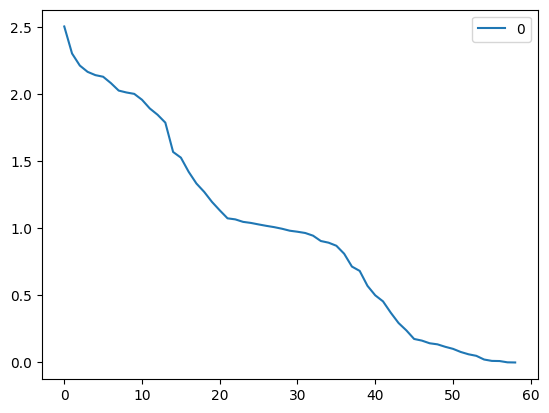

In [134]:
# Eigenvalues
df_explained_variance = pd.DataFrame(pca.explained_variance_)
df_explained_variance.plot()
plt.show()

In [135]:
# Eigenvector
df_components = pd.DataFrame(pca.components_)
df_components.head()

0         1         2         3         4         5         6   \
0  0.020577 -0.049864  0.003606  0.013911 -0.000937  0.316810 -0.135152   
1  0.005950  0.018649 -0.111002  0.000202 -0.029195 -0.082858 -0.155080   
2  0.004018 -0.128370  0.089109 -0.015372 -0.049569  0.060150 -0.005196   
3 -0.023302 -0.083737  0.013102 -0.014227  0.026774 -0.104058 -0.100035   
4 -0.016118  0.046710 -0.011762 -0.005977  0.010790 -0.016754 -0.039032   

         7         8         9   ...        49        50        51        52  \
0  0.152173 -0.144052 -0.011730  ... -0.081348  0.022573 -0.159924 -0.066052   
1  0.189320  0.017337  0.124931  ...  0.028318  0.052723  0.007697 -0.138524   
2 -0.010717 -0.112388 -0.180152  ... -0.062675  0.035253 -0.220749  0.007498   
3  0.210413 -0.052782  0.043971  ...  0.068085 -0.053382  0.220343 -0.176805   
4  0.013303 -0.089393  0.020223  ...  0.015348  0.105534  0.171245 -0.250399   

         53        54        55        56        57        58  
0 -0.009856  0.070775 -0.021370 -0.219904 -0.039123  0.388765  
1 -0.003859  0.074777 -0.183004  0.032514 -0.030071 -0.187258  
2  0.013898 -0.100180  0.031422  0.213290  0.111404 -0.097308  
3  0.011204  0.157677 -0.060459 -0.211992 -0.018854 -0.091284  
4  0.002506 -0.056339  0.008952  0.450861 -0.085981  0.159675  

[5 rows x 59 columns]

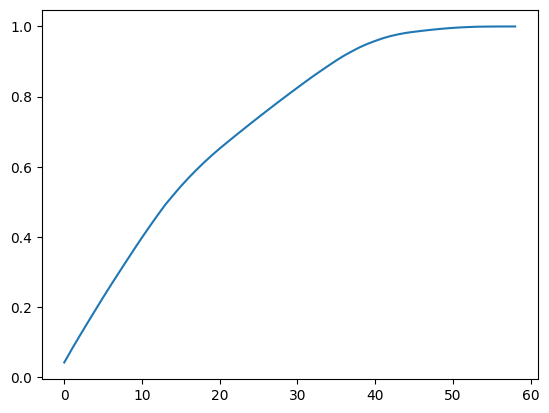

In [136]:
# Explained variance
df_explained_var_ratio = pd.DataFrame(pca.explained_variance_ratio_)
df_explained_var_ratio['cumsum'] = df_explained_var_ratio.cumsum()
df_explained_var_ratio['cumsum'].plot()
plt.show()

In [137]:
n_components = df_explained_var_ratio[df_explained_var_ratio['cumsum'] >= 0.9].index[0]
n_components

35

In [139]:
pca_new = PCA(n_components=n_components)
pca_new.fit(X_train_scaled)
X_train_pca = pd.DataFrame(pca_new.transform(X_train_scaled))
X_train_pca

0         1         2         3         4         5         6   \
0      1.426462 -0.670854  0.205634 -0.601433 -0.082540  0.527882 -0.067977   
1      1.424897 -0.622667  0.166950 -0.607121 -0.077434  0.577688 -0.091499   
2      1.426137 -0.660856  0.197607 -0.602614 -0.081480  0.538216 -0.072858   
3      1.422756 -0.556757  0.114040 -0.614901 -0.070449  0.645811 -0.123671   
4      1.424632 -0.614530  0.160418 -0.608082 -0.076571  0.586098 -0.095470   
...         ...       ...       ...       ...       ...       ...       ...   
61687  1.794464 -1.150231 -0.246773 -0.072470  0.121754  0.150514 -0.383743   
61688  1.742584 -0.986532 -0.327301 -0.044278  0.159167  0.257316 -0.471820   
61689  1.774062 -0.995951 -0.286077 -0.047201  0.131925  0.238863 -0.475366   
61690  1.779041 -1.149215 -0.163041 -0.029111  0.115684  0.080451 -0.400554   
61691  1.774637 -1.013649 -0.271869 -0.045112  0.130049  0.220570 -0.466727   

             7         8         9   ...        25        26        27  \
0      0.778578  1.652178  0.070454  ... -0.205556  0.096437  0.141457   
1      0.795782  1.647547  0.074510  ... -0.141500  0.130045  0.172126   
2      0.782148  1.651218  0.071295  ... -0.192265  0.103411  0.147821   
3      0.819314  1.641213  0.080057  ... -0.053885  0.176013  0.214075   
4      0.798687  1.646765  0.075194  ... -0.130684  0.135720  0.177305   
...         ...       ...       ...  ...       ...       ...       ...   
61687  0.065360 -0.174958 -0.008686  ... -0.556729  0.255855 -0.217543   
61688  0.093316 -0.196592 -0.005863  ... -0.831474  1.067631  0.331861   
61689  0.085670 -0.217349 -0.004350  ... -0.736229  1.053675  0.132282   
61690  0.030950 -0.202619 -0.017249  ... -0.939965  0.946784  0.034737   
61691  0.079351 -0.215648 -0.005840  ... -0.759756  1.041332  0.121018   

             28        29        30        31        32        33        34  
0      0.438274  0.122248  0.310910  0.259904  0.138544 -0.697068  0.553197  
1      0.395866  0.033221  0.319135  0.297219  0.140849 -0.867836  0.414533  
2      0.429475  0.103776  0.312617  0.267646  0.139022 -0.732502  0.524425  
3      0.337859 -0.088549  0.330385  0.348257  0.144001 -1.101410  0.224871  
4      0.388705  0.018188  0.320524  0.303520  0.141238 -0.896671  0.391119  
...         ...       ...       ...       ...       ...       ...       ...  
61687 -0.569930  1.386450 -0.656217 -1.563027  0.886317  0.234389  0.850810  
61688  0.389397  0.053328  0.612606 -0.044513 -0.182924 -0.616496  0.278361  
61689  0.305342  0.462305  0.684908  0.569063 -0.046144 -0.601966  0.311066  
61690  0.440227  0.745463  0.658749  0.450380 -0.053474 -0.058824  0.752097  
61691  0.320918  0.495003  0.681888  0.555358 -0.046991 -0.539246  0.361994  

[61692 rows x 35 columns]

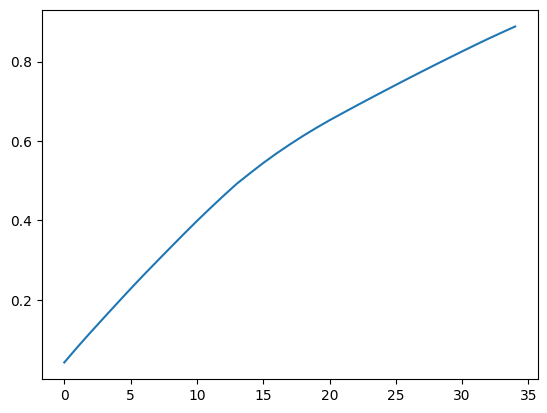

In [140]:
# Explained variance
df_explained_var_ratio_new = pd.DataFrame(pca_new.explained_variance_ratio_)
df_explained_var_ratio_new['cumsum'] = df_explained_var_ratio_new.cumsum()
df_explained_var_ratio_new['cumsum'].plot()
plt.show()